# 导入工具

[Credit](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

In [48]:
import warnings
warnings.filterwarnings('ignore')
import gc
from numba import jit
from tqdm import tqdm_notebook, tqdm
tqdm.pandas()
import sys
import os
import re
import json
import logging
logging.basicConfig(format="%(asctime)s: %(levelname)s: %(message)s", level=logging.INFO)

from bs4 import BeautifulSoup

import numpy as np
np.set_printoptions(suppress=True, precision=3)
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)
import pandas_profiling
import seaborn as sns
sns.set()
import matplotlib.pyplot as  plt
import matplotlib.patches as patches
plt.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline

from collections import defaultdict, Counter
from nltk.corpus import stopwords
from attention import AttentionLayer

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.layers import Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.python.framework import ops

print(tf.__version__)

2.0.0


# 查看数据 

In [2]:
data = pd.read_csv('data/Reviews.csv', nrows=10000)

In [3]:
data.drop_duplicates(subset=['Text'], inplace=True)
data.dropna(axis=0, inplace=True, subset=['Text'])

In [4]:
data.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [6]:
data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...


# 准备数据

In [7]:
data.Text[:2]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Name: Text, dtype: object

In [8]:
data.Summary[:2]

0    Good Quality Dog Food
1        Not as Advertised
Name: Summary, dtype: object

## 文本与摘要清洗
- 转小写
- 缩写转全写
- 删除html标签
- 去除停用词

In [14]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"}

In [15]:
def clean_text(text, remove_stopwords=True, bos_and_eos=False):
    text = text.lower()
    new_text = []
    for word in text.split():
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = ' '.join(new_text)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[>_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'<br', ' ',text)
    text = re.sub(r'><br', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text  = [word for word in text if not word in stops]
        text = ' '.join(text)
    
    if bos_and_eos:
        text = ' '.join(['bos', text, 'eos'])
    return text

In [16]:
# 摘要不去除停用词，且前后加上开始与结束标签
data['Cleaned_Summary'] = data.Summary.apply(clean_text, args=(False,True))
data['Cleaned_Text'] = data.Text.apply(clean_text)

In [17]:
data[['Text', 'Summary', 'Cleaned_Summary', 'Cleaned_Text']].head(3)

,Text,Summary,Cleaned_Summary,Cleaned_Text
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,Good Quality Dog Food,bos good quality dog food eos,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Not as Advertised,bos not as advertised eos,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...","""Delight"" says it all",bos delight says it all eos,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...


In [18]:
data_pure = data[['Text', 'Summary', 'Cleaned_Summary', 'Cleaned_Text']].copy()
data_pure.head(2)

,Text,Summary,Cleaned_Summary,Cleaned_Text
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,Good Quality Dog Food,bos good quality dog food eos,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Not as Advertised,bos not as advertised eos,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo


In [19]:
data_pure.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9513 entries, 0 to 9999
Data columns (total 4 columns):
Text               9513 non-null object
Summary            9513 non-null object
Cleaned_Summary    9513 non-null object
Cleaned_Text       9513 non-null object
dtypes: object(4)
memory usage: 371.6+ KB


## 查看长度范围，确定统一长度

In [20]:
data_pure['Text_Length'] = data_pure.Cleaned_Text.apply(lambda x:len(x.split()))
data_pure['Summary_Length'] = data_pure.Cleaned_Summary.apply(lambda x:len(x.split()))
data_pure.head(3)

,Text,Summary,Cleaned_Summary,Cleaned_Text,Text_Length,Summary_Length
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,Good Quality Dog Food,bos good quality dog food eos,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,23,6
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Not as Advertised,bos not as advertised eos,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,18,5
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...","""Delight"" says it all",bos delight says it all eos,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,40,6


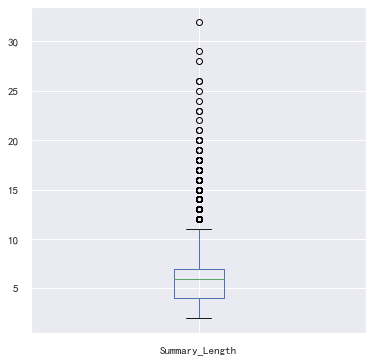

count    9513.000000
mean        6.140545
std         2.663633
min         2.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        32.000000
Name: Summary_Length, dtype: float64

In [21]:
data_pure.Summary_Length.plot.box(figsize=(6,6))
plt.show()
data_pure.Summary_Length.describe()

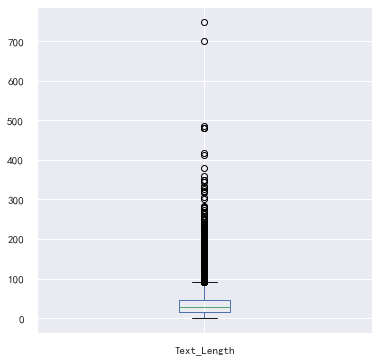

count    9513.000000
mean       38.003574
std        37.029990
min         0.000000
25%        16.000000
50%        27.000000
75%        46.000000
max       749.000000
Name: Text_Length, dtype: float64

In [22]:
data_pure.Text_Length.plot.box(figsize=(6,6))
plt.show()
data_pure.Text_Length.describe()

In [23]:
max_len_text = 80
max_len_summary = 10

## 分离训练，验证，测试集

In [24]:
train_features, valid_features, train_labels, valid_labels = train_test_split(data_pure.Cleaned_Text,
                                                                               data_pure.Cleaned_Summary, test_size=.1,
                                                                               random_state=0, shuffle=True)
train_features.shape, valid_features.shape, train_labels.shape, valid_labels.shape

((8561,), (952,), (8561,), (952,))

## Tokenizer

In [25]:
train_tokenizer = Tokenizer()
train_tokenizer.fit_on_texts(list(train_features))
train_word2index = train_tokenizer.word_index
train_seq = train_tokenizer.texts_to_sequences(train_features)
valid_seq = train_tokenizer.texts_to_sequences(valid_features)

paded_train_seq = pad_sequences(train_seq, maxlen=max_len_text, padding='post')
paded_valid_seq = pad_sequences(valid_seq, maxlen=max_len_text, padding='post')

train_vocab_size = len(train_word2index) + 1

In [26]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(list(train_labels))
label_word2index = label_tokenizer.word_index
train_label_seq = label_tokenizer.texts_to_sequences(train_labels)
valid_label_seq = label_tokenizer.texts_to_sequences(valid_labels)

paded_train_label_seq = pad_sequences(train_label_seq, maxlen=max_len_summary, padding='post')
paded_valid_label_seq = pad_sequences(valid_label_seq, maxlen=max_len_summary, padding='post')

label_vocab_size = len(label_word2index) + 1

In [27]:
train_vocab_size, label_vocab_size

(17306, 4288)

# 模型

In [29]:
latent_dim = 500
def build_model(latent_dim):
    ops.reset_default_graph()
    # Encoder
    encoder_inputs = Input(shape=(max_len_text,))
    enc_emb = Embedding(train_vocab_size, latent_dim, trainable=True)(encoder_inputs)
    
    # LSTM1
    encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
    encoder_outputs1, state_h1, state_c1 = encoder_lstm1(enc_emb)
    
    # LSTM2
    encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
    encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
    
    # LSTM3
    encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm3(encoder_outputs2)
    
    # Decoder
    decoder_inputs = Input(shape=(None,))
    dec_emb_layer = Embedding(label_vocab_size, latent_dim, trainable=True)
    dec_emb = dec_emb_layer(decoder_inputs)
    
    # Using LSTM encoder_state as initial state
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, 
                                                                          initial_state=[state_h, state_c])
    
    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
    
    # Concating attention layer output and decoder LSTM output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
    
    # Dense layer
    decoder_dense = TimeDistributed(Dense(label_vocab_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_concat_input)
    
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

In [30]:
model = build_model(latent_dim)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      8653000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [81]:
# callbacks 
# lr_schedule = ExponentialDecay(.1,decay_steps=10000,decay_rate=.96,staircase=True)
csv_logger = CSVLogger('temp/csv_logger2')
stop_callback = EarlyStopping(monitor='val_loss',mode='min',verbose=1)

checkpoint_path = 'temp/training_checkpoints/'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(checkpoint_dir,save_weights_only=True,verbose=1)

In [59]:
history = model.fit([paded_train_seq, paded_train_label_seq[:,:-1]], 
                    paded_train_label_seq.reshape(*paded_train_label_seq.shape, 1)[:, 1:],
                    validation_data=([paded_valid_seq, paded_valid_label_seq[:,:-1]], 
                                     paded_valid_label_seq.reshape(*paded_valid_label_seq.shape, 1)[:,1:]),
                    epochs=50, 
                    batch_size=512,
                    callbacks=[csv_logger, stop_callback, cp_callback])
logger = pd.DataFrame(history.history)
logger.plot(figsize=(6,6))

Train on 8561 samples, validate on 952 samples
Epoch 1/50
8192/8561 [===========================>..] - ETA: 11:41 - loss: 2.91 - ETA: 10:55 - loss: 2.87 - ETA: 10:09 - loss: 2.83 - ETA: 9:22 - loss: 2.8248 - ETA: 8:37 - loss: 2.807 - ETA: 7:52 - loss: 2.822 - ETA: 7:09 - loss: 2.821 - ETA: 6:26 - loss: 2.831 - ETA: 5:43 - loss: 2.834 - ETA: 5:01 - loss: 2.826 - ETA: 4:17 - loss: 2.819 - ETA: 3:33 - loss: 2.838 - ETA: 2:48 - loss: 2.844 - ETA: 2:03 - loss: 2.845 - ETA: 1:18 - loss: 2.843 - ETA: 32s - loss: 2.8472 
Epoch 00001: saving model to temp/training_checkpoints
8561/8561 [==============================] - 776s 91ms/sample - loss: 2.8444 - val_loss: 2.7539
Epoch 2/50
8192/8561 [===========================>..] - ETA: 10:42 - loss: 2.78 - ETA: 10:29 - loss: 2.76 - ETA: 9:55 - loss: 2.7504 - ETA: 9:14 - loss: 2.757 - ETA: 8:32 - loss: 2.776 - ETA: 7:50 - loss: 2.785 - ETA: 7:07 - loss: 2.781 - ETA: 6:24 - loss: 2.787 - ETA: 5:41 - loss: 2.785 - ETA: 4:58 - loss: 2.792 - ETA: 4:15 - l

In [9]:
logger = pd.read_csv('temp/csv_logger')
logger

,epoch,loss,val_loss
0,0,4.290843,3.180711
1,1,3.227364,2.927936
2,2,3.051676,2.814775
3,3,2.964435,2.792177
4,4,2.867706,2.747863
5,5,2.809038,2.772846
6,6,2.758647,2.728798
7,7,2.716092,2.733078
8,8,2.664167,2.706336
9,9,2.603078,2.701337


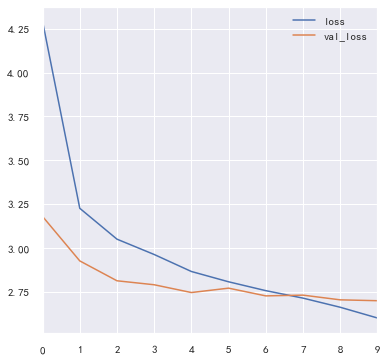

In [13]:
logger[['loss', 'val_loss']].plot(figsize=(6,6))
plt.show()

# 保存模型

## 回调函数自动保存与手动保存权重

In [73]:
# get callback's saved checkpoint file
latest = tf.train.latest_checkpoint(checkpoint_dir)
new_model = build_model(latent_dim)
new_model.load_weights(latest)

In [ ]:
# save weights manually
model.save_weights('temp/training_checkpoints/manually_checkpoint')

# load weights with new model instance
new_model = build_model(latent_dim)
new_model.load_weights('temp/training_checkpoints/manually_checkpoint')

## 保存全部模型
- 如果引入手动实现的网络层，会出错，如此模型中的注意力层

In [ ]:
# save whole model
model.save('saved_model/model.h5')

# load whole model from that file
new_model = load_model('saved_model/model.h5')
new_model.summary()

---

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=50,callbacks=[es],batch_size=512, 
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))  

In [93]:
x_tr = paded_train_seq
y_tr = paded_train_label_seq
x_val = paded_valid_seq
y_val = paded_valid_label_seq

In [95]:
x_tr.shape,y_tr[:,:-1].shape

((8561, 80), (8561, 9))

In [98]:
y_tr.reshape(*y_tr.shape, 1)[:,1:].shape

(8561, 9, 1)

## 统计 

In [85]:
# 统计单词字典 
word_dict_text = [word for sentence in df.Cleaned_Text for word in sentence.split()]
word_dict_summary = [word for sentence in df.Cleaned_Summary for word in sentence.split()]
dict_corpus = Counter(word_dict_summary) + Counter(word_dict_text)
dict_corpus.most_common(10), len(dict_corpus)

([('food', 69),
  ('good', 53),
  ('great', 53),
  ('dog', 42),
  ('like', 37),
  ('oatmeal', 35),
  ('taste', 28),
  ('product', 26),
  ('love', 23),
  ('instant', 22)],
 1479)

In [90]:
sorted(dict_corpus.items(), key=lambda x: x[1], reverse=1)

[('food', 69),
 ('good', 53),
 ('great', 53),
 ('dog', 42),
 ('like', 37),
 ('oatmeal', 35),
 ('taste', 28),
 ('product', 26),
 ('love', 23),
 ('instant', 22),
 ('sugar', 21),
 ('one', 21),
 ('would', 20),
 ('really', 19),
 ('little', 19),
 ('mccann', 19),
 ('use', 18),
 ('hot', 17),
 ('better', 17),
 ('natural', 17),
 ('time', 16),
 ('sauce', 15),
 ('flavor', 15),
 ('get', 15),
 ('water', 15),
 ('price', 14),
 ('buy', 14),
 ('coffee', 14),
 ('balance', 14),
 ('flavors', 14),
 ('twizzlers', 13),
 ('candy', 13),
 ('much', 13),
 ('dogs', 13),
 ('well', 13),
 ('make', 13),
 ('best', 12),
 ('for', 12),
 ('variety', 12),
 ('eat', 12),
 ('also', 12),
 ('taffy', 11),
 ('the', 11),
 ('regular', 11),
 ('free', 11),
 ('got', 11),
 ('brand', 11),
 ('could', 11),
 ('take', 11),
 ('store', 11),
 ('chocolate', 10),
 ('find', 10),
 ('tried', 10),
 ('amazon', 10),
 ('brown', 10),
 ('milk', 10),
 ('quality', 9),
 ('day', 9),
 ('tastes', 9),
 ('ever', 9),
 ('allergies', 9),
 ('bought', 9),
 ('found', 9)

In [55]:
# 使用预训练词向量：https://github.com/commonsense/conceptnet-numberbatch
embedding_index = defaultdict(str)
with open('data/numberbatch-en.txt', encoding='utf-8') as f:
    for line in f:
        value = line.split(' ')
        word = value[0]
        embedding = np.asarray(value[1:], dtype='float32')
        embedding_index[word] = embedding

In [130]:
threshold = 15
missing_words = []
for word, counts in dict_corpus.items():
    if counts > threshold:
        if word not in embedding_index:
            missing_words.append(word)
missing_ratio = round(len(missing_words) / len(dict_corpus), 4)
missing_words, missing_ratio

([], 0.0)

In [131]:
len([w for w in dict_corpus if dict_corpus[w] > threshold])

21

In [132]:
# 单词:索引映射
corpus_words = [w for w in dict_corpus.keys() if dict_corpus[w] > threshold]
vocab_to_index = {word: corpus_words.index(word) for word in corpus_words}
vocab_to_index

{'good': 0,
 'dog': 1,
 'food': 2,
 'great': 3,
 'hot': 4,
 'love': 5,
 'better': 6,
 'taste': 7,
 'product': 8,
 'instant': 9,
 'oatmeal': 10,
 'would': 11,
 'time': 12,
 'like': 13,
 'natural': 14,
 'sugar': 15,
 'one': 16,
 'really': 17,
 'use': 18,
 'little': 19,
 'mccann': 20}

In [133]:
padding_token = ['<UNK>', '<PAD>', '<EOS>', '<BOS>']
for token in padding_token:
    vocab_to_index[token] = len(vocab_to_index)

In [134]:
index_to_vocab = {value:key for key, value in vocab_to_index.items()}
usage_ratio = round(len(vocab_to_index) / len(dict_corpus), 4)
print(f"Total number of unique words: {len(dict_corpus)}")
print(f"Number of words we will use: {len(vocab_to_index)}")
print(f"Percent of words we will use: {usage_ratio * 100}%")

Total number of unique words: 1479
Number of words we will use: 25
Percent of words we will use: 1.69%


In [135]:
embedding_dim = 300 # same as pre-trained embedding
nb_words = len(vocab_to_index)

word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype='float32')
print(word_embedding_matrix.shape)

for word, index in vocab_to_index.items():
    if word in embedding_index:
        word_embedding_matrix[index] = embedding_index[word]
    else:  # padding token's random embedding
        new_embedding = np.array(np.random.rand(embedding_dim))
        word_embedding_matrix[index] = new_embedding
print(len(word_embedding_matrix))

(25, 300)
25


In [155]:
# 句子:索引映射
def sentence_to_int(texts, word_count=0, unk_count=0, eos=False):
    text_ints = []
    for sentence in texts:
        result = []
        split = sentence.split()
        word_count += len(split)
        for word in split:
            if word in vocab_to_index:
                result.append(vocab_to_index[word])
            else:
                result.append(vocab_to_index['<UNK>'])
                unk_count += 1
        if eos:
            result.append('<EOS>')
        text_ints.append(result)
    return text_ints, word_count, unk_count

In [159]:
result_sum, word_count_sum, unk_count_sum = sentence_to_int(df.Cleaned_Summary)
result_text, word_count_text, unk_count_text = sentence_to_int(df.Cleaned_Text, eos=True)
word_count = word_count_sum + word_count_text
unk_count = unk_count_sum + unk_count_text
unk_percent = round(unk_count / word_count, 4)
print(f"Total number of words in text and summary is: {word_count}")
print(f"Total number of unkonw token in text and summary is: {unk_count}")
print(f"Percent or words that are UNK is: {unk_percent * 100}%")

Total number of words in text and summary is: 3748
Total number of unkonw token in text and summary is: 3156
Percent or words that are UNK is: 84.2%


In [162]:
df.head(3)

,Summary,Text,Cleaned_Summary,Cleaned_Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,good quality dog food,bought several vitality canned dog food produc...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,not as advertised,product arrived labeled jumbo salted peanuts p...
2,"""Delight"" says it all",This is a confection that has been around a fe...,delight says it all,confection around centuries light pillowy citr...


In [185]:
df['Clean_Text_Length'] = df.Cleaned_Text.apply(lambda x: len(x.split()))
df['Clean_Summary_Length'] = df.Cleaned_Summary.apply(lambda x: len(x.split()))
df.describe()

,Clean_Text_Length,Clean_Summary_Length
count,100.000000,100.000000
mean,33.500000,3.980000
std,33.487673,2.534529
min,3.000000,1.000000
25%,13.000000,2.000000
50%,22.000000,3.000000
75%,40.000000,5.000000
max,216.000000,12.000000


22.0
103.24999999999999
159.57000000000028


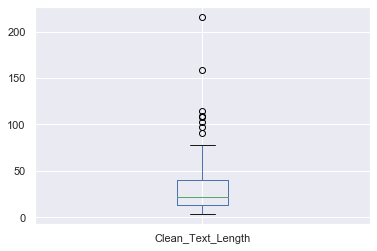

In [201]:
print(np.percentile(df.Clean_Text_Length, 50))
print(np.percentile(df.Clean_Text_Length, 95))
print(np.percentile(df.Clean_Text_Length, 99))
df.Clean_Text_Length.plot.box()
plt.show()

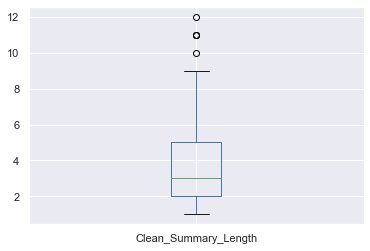

In [198]:
df.Clean_Summary_Length.plot.box()

# 建立训练模型

用的API太旧了。

# 摘要